In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
%matplotlib inline

C:\Users\User\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
df = pd.read_csv("data/rsbuddy/buy_average.csv")
df = df.set_index('timestamp')
df2 = pd.read_csv("data/rsbuddy/sell_average.csv")
df2 = df2.set_index('timestamp')

In [3]:
dropped = df.drop_duplicates()
dropped2 = df2.drop_duplicates()
selected = dropped[['Chaos_rune', 'Nature_rune', 'Soul_rune', 'Blood_rune', 'Law_rune', 'Rune_axe']]
selected = selected.replace(to_replace=0, method='ffill')
selected2 = dropped2[['Chaos_rune', 'Nature_rune', 'Soul_rune', 'Blood_rune', 'Law_rune']]
# y = runes.reset_index()['Chaos_rune']

In [4]:
print(selected.shape)
print(selected2.shape)
selected.head()

(1086, 6)
(1086, 5)


,Chaos_rune,Nature_rune,Soul_rune,Blood_rune,Law_rune,Rune_axe
timestamp,,,,,,
1577227800,66,218,146,305,142,7196
1577229600,66,219,147,304,142,7123
1577231400,66,218,146,304,142,7237
1577233501,66,218,145,304,140,7250
1577235300,66,218,144,301,140,7316


# Using the tsfresh library

In [ ]:
import scipy as sp
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import make_forecasting_frame
from sklearn.ensemble import AdaBoostRegressor
from tsfresh.utilities.dataframe_functions import impute

In [ ]:
selected['Rune_axe'].plot(figsize=(15, 6))
plt.show()

In [ ]:
df_shift, y = make_forecasting_frame(selected["Rune_axe"], kind="buy_average", max_timeshift=20, rolling_direction=1)

In [ ]:
df_shift.head()

In [ ]:
df_shift.shape

In [ ]:
%%capture
X = extract_features(df_shift, column_id="id", column_sort="time", column_value="value", impute_function=impute, show_warnings=False)

In [ ]:
# drop constant features
print(X.shape)
X = X.loc[:, X.apply(pd.Series.nunique) != 1] 
print(X.shape)

In [ ]:
# Add last value as feature
X["feature_last_value"] = y.shift(1)

In [ ]:
# Drop first line
X = X.iloc[1:, ]
y = y.iloc[1: ]

In [ ]:
X.head()

In [ ]:

from tqdm import tqdm

In [ ]:
ada = AdaBoostRegressor(n_estimators=10)
y_pred = [np.NaN] * len(y)

isp = 100   # index of where to start the predictions
assert isp > 0

for i in tqdm(range(isp, len(y))):
    
    ada.fit(X.iloc[:i], y[:i])
    y_pred[i] = ada.predict(X.iloc[i, :].values.reshape((1, -1)))[0]
    
y_pred = pd.Series(data=y_pred, index=y.index)

In [ ]:

# Dataframe of predictions and true values
ys = pd.concat([y_pred, y], axis = 1).rename(columns = {0: 'pred', 'value': 'true'})

# Convert index to a datetime
ys.index = pd.to_datetime(ys.index)
ys.head()

In [ ]:
ys.plot(figsize=(15, 8))
plt.title('Predicted and True Price')
plt.show()

In [ ]:
# Create column of previous price
ys['y-1'] = ys['true'].shift(1)
ys[['y-1', 'true']].plot(figsize = (15, 8))
plt.title('Benchmark Prediction and True Price')
plt.show()

In [ ]:
print("MAE y-1: \t{}".format(np.mean(np.abs(np.diff(y))[isp-1:] )))
print("MAE ada: \t{}".format(np.mean(np.abs(y_pred - y)[isp:])))

In [ ]:
importances = pd.Series(index=X.columns, data=ada.feature_importances_)
importances.sort_values(ascending=False).head(10)

# Using known finance features

In [5]:
def moving_average_convergence(group, nslow=26, nfast=12):
    emaslow = group.ewm(span=nslow, min_periods=1).mean()
    emafast = group.ewm(span=nfast, min_periods=1).mean()
    result = pd.DataFrame({'MACD': emafast-emaslow, 'emaSlw': emaslow, 'emaFst': emafast})
    return result

def moving_average(group, n=9):
    sma = group.rolling(n).mean()
    return sma

In [6]:
print(selected.shape)
print(selected2.shape)
selected.head()

(1086, 6)
(1086, 5)


,Chaos_rune,Nature_rune,Soul_rune,Blood_rune,Law_rune,Rune_axe
timestamp,,,,,,
1577227800,66,218,146,305,142,7196
1577229600,66,219,147,304,142,7123
1577231400,66,218,146,304,142,7237
1577233501,66,218,145,304,140,7250
1577235300,66,218,144,301,140,7316


In [7]:
myResult = moving_average_convergence(selected['Rune_axe'])
sma = moving_average(selected['Rune_axe'])

In [8]:
print(myResult.shape)
myResult.head()

(1086, 3)


,MACD,emaSlw,emaFst
timestamp,,,
1577227800,0.000000,7196.000000,7196.000000
1577229600,-1.637821,7158.096154,7156.458333
1577231400,1.448225,7186.445540,7187.893764
1577233501,3.285686,7204.212589,7207.498276
1577235300,6.841255,7230.136551,7236.977807


In [9]:
sma.head(15)

timestamp
1577227800            NaN
1577229600            NaN
1577231400            NaN
1577233501            NaN
1577235300            NaN
1577237100            NaN
1577238900            NaN
1577240701            NaN
1577242500    7237.222222
1577244300    7233.444444
1577246100    7238.111111
1577247901    7230.555556
1577249700    7220.888889
1577251500    7207.333333
1577253301    7204.555556
Name: Rune_axe, dtype: float64

In [10]:
def RSI(price, n=14):
    delta = price.diff()
    dUp, dDown = delta.copy(), delta.copy()
    dUp[dUp < 0] = 0
    dDown[dDown > 0] = 0

    RolUp = dUp.rolling(n).mean()
    RolDown = dDown.rolling(n).mean().abs()
    
    RS = RolUp / RolDown
    rsi= 100.0 - (100.0 / (1.0 + RS))
    return rsi

In [11]:
rsi = RSI(selected['Rune_axe'], 10)
rsi = rsi.rename("RSI")
rsi.head(15)

timestamp
1577227800          NaN
1577229600          NaN
1577231400          NaN
1577233501          NaN
1577235300          NaN
1577237100          NaN
1577238900          NaN
1577240701          NaN
1577242500          NaN
1577244300          NaN
1577246100    47.495961
1577247901    54.181818
1577249700    41.628959
1577251500    43.913043
1577253301    33.830846
Name: RSI, dtype: float64

In [12]:
selected['datetime'] = selected.index
selected['datetime'] = pd.to_datetime(selected['datetime'], unit='s')
selected['dayofweek'] = selected['datetime'].dt.dayofweek
selected['hour'] = selected['datetime'].dt.hour
selected['minute'] = selected['datetime'].dt.minute

selected.head()

,Chaos_rune,Nature_rune,Soul_rune,Blood_rune,Law_rune,Rune_axe,datetime,dayofweek,hour,minute
timestamp,,,,,,,,,,
1577227800,66,218,146,305,142,7196,2019-12-24 22:50:00,1,22,50
1577229600,66,219,147,304,142,7123,2019-12-24 23:20:00,1,23,20
1577231400,66,218,146,304,142,7237,2019-12-24 23:50:00,1,23,50
1577233501,66,218,145,304,140,7250,2019-12-25 00:25:01,2,0,25
1577235300,66,218,144,301,140,7316,2019-12-25 00:55:00,2,0,55


In [13]:
tmp = selected.copy()
tmp.index = pd.to_datetime(tmp.index)

slope = pd.Series(np.gradient(tmp['Rune_axe']), tmp.index, name='slope')

df = pd.concat([tmp, slope], axis=1)
df.head()

,Chaos_rune,Nature_rune,Soul_rune,Blood_rune,Law_rune,Rune_axe,datetime,dayofweek,hour,minute,slope
timestamp,,,,,,,,,,,
1970-01-01 00:00:01.577227800,66,218,146,305,142,7196,2019-12-24 22:50:00,1,22,50,-73.0
1970-01-01 00:00:01.577229600,66,219,147,304,142,7123,2019-12-24 23:20:00,1,23,20,20.5
1970-01-01 00:00:01.577231400,66,218,146,304,142,7237,2019-12-24 23:50:00,1,23,50,63.5
1970-01-01 00:00:01.577233501,66,218,145,304,140,7250,2019-12-25 00:25:01,2,0,25,39.5
1970-01-01 00:00:01.577235300,66,218,144,301,140,7316,2019-12-25 00:55:00,2,0,55,-19.5


In [14]:
from scipy import integrate

def integrate_method(self, how='trapz', unit='s'):
    available_rules = set(['trapz', 'cumtrapz', 'simps', 'romb'])
    if how in available_rules:
        rule = integrate.__getattribute__(how)
    else:
        print('Unsupported integration rule: %s' % (how))
        print('Expecting one of these sample-based integration rules: %s' % (str(list(available_rules))))
        raise AttributeError
    
    result = rule(self.values, self.index.astype(np.int64) / 10**9)
    #result = rule(self.values)
    return result

pd.Series.integrate = integrate_method

integral = pd.Series(tmp['Rune_axe'].integrate('cumtrapz'))
integral.head()

0    0.012887
1    0.025811
2    0.041030
3    0.054132
4    0.067206
dtype: float64

In [15]:
# Univariate linear regression tests and Recursive Feature Elimination (RFE)
from sklearn import datasets
from sklearn.feature_selection import RFE, f_regression, SelectKBest
from sklearn.linear_model import LogisticRegression

## Regression F Test

In [16]:
# generate dataset
X, y = datasets.make_regression(n_samples=100, n_features=100, n_informative=10)
print(X.shape)
print(y.shape)

# define feature selection
fs = SelectKBest(score_func=f_regression, k=10)
# apply feature selection
X_selected = fs.fit_transform(X, y)
print(X_selected.shape)

(100, 100)
(100,)
(100, 10)


In [17]:
features = df.drop(['datetime'], axis=1).copy()

# normalize dataset
dataset=(features-features.mean())/features.std()

X = dataset.drop(['Rune_axe'], axis=1)
y = dataset['Rune_axe']
print(X.shape)
print(y.shape)

# define feature selection
fs = SelectKBest(score_func=f_regression, k=3)
# apply feature selection
X_selected = fs.fit_transform(X, y)
print(X_selected.shape)

# Get scores for each of the columns
scores = fs.scores_
print(scores)

# Get columns to keep and create new dataframe with those only
cols = fs.get_support(indices=True)
features_df_new = X.iloc[:,cols]
features_df_new.head()


(1086, 9)
(1086,)
(1086, 3)
[1.28626315e+00 1.35550776e+01 1.23028012e+01 4.13374258e+00
 4.74967310e+00 3.34798400e-01 6.40409953e-01 7.08422784e-01
 9.16721174e-06]


,Nature_rune,Soul_rune,Law_rune
timestamp,,,
1970-01-01 00:00:01.577227800,-1.778269,0.140424,-0.652196
1970-01-01 00:00:01.577229600,-1.714797,0.425472,-0.652196
1970-01-01 00:00:01.577231400,-1.778269,0.140424,-0.652196
1970-01-01 00:00:01.577233501,-1.778269,-0.144624,-0.855143
1970-01-01 00:00:01.577235300,-1.778269,-0.429672,-0.855143


## Recursive Feature Elimination (RFE)

In [18]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot

C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Selected Features:
Nature_rune
Law_rune
hour
slope


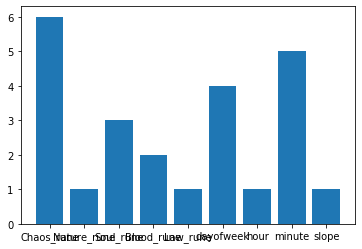

In [19]:
X = dataset.drop(['Rune_axe'], axis=1)
y = dataset['Rune_axe']

# perform feature selection
rfe = RFE(RandomForestRegressor(n_estimators=500, random_state=1), 4)
fit = rfe.fit(X, y)
# report selected features
print('Selected Features:')
names = dataset.drop(['Rune_axe'], axis=1).columns.values
for i in range(len(fit.support_)):
    if fit.support_[i]:
        print(names[i])
        
# plot feature rank
names = dataset.drop(['Rune_axe'], axis=1).columns.values
ticks = [i for i in range(len(names))]
pyplot.bar(ticks, fit.ranking_)
pyplot.xticks(ticks, names)
pyplot.show()